In [1]:
# Load images and labels
import os
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt

# # Define the input directory
input_dir = 'C:/Users/odys_/Desktop/ML_winows_2/archive_small'

# Initialize lists to store images and labels
images = []
labels = []

# Loop through each folder (class name) in the input directory
for category in os.listdir(input_dir):
    category_path = os.path.join(input_dir, category)
    if os.path.isdir(category_path):  # Ensure it's a directory
        for file_name in os.listdir(category_path):
            if file_name.endswith('.jpeg') or file_name.endswith('.png'):  # Check for valid image files
                img_path = os.path.join(category_path, file_name)
                try:
                    # Open and preprocess the image
                    img = Image.open(img_path)
                    # img = img.resize((128, 128))  # Resize to 128x128
                    img_array = np.array(img)
                    
                    # Append the image and its label
                    images.append(img_array)
                    labels.append(category)  # Use the folder name as the label
                except Exception as e:
                    print(f"Error loading image {img_path}: {e}")

# Convert lists to numpy arrays
images = np.array(images)
labels = np.array(labels)

# Print some information about the loaded data
print(f"Loaded {len(images)} images.")
print(f"Image shape: {images[0].shape} ")
print(f"Labels: {np.unique(labels)}")


Loaded 600 images.
Image shape: (64, 64) 
Labels: ['AbdomenCT' 'BreastMRI' 'Hand' 'HeadCT']


In [2]:
from sklearn.model_selection import train_test_split

# Set random_state for reproducibility
random_state = 42

# Split into train and test only
X_train, X_test, y_train, y_test = train_test_split(
    images, labels, test_size=0.3, random_state=random_state, stratify=labels
)

print(f"Shape Train set: {X_train.shape}, labels: {y_train.shape}")
print(f"Shape Test set: {X_test.shape}, labels:{y_test.shape}")

Shape Train set: (420, 64, 64), labels: (420,)
Shape Test set: (180, 64, 64), labels:(180,)


In [3]:
# LDA (Linear Discriminant Analysis) 

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler

# Flatten images for LDA
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# Standardize features
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train_flat)
X_test_std = scaler.transform(X_test_flat)

# Number of LDA components (at most n_classes - 1)
n_classes = len(np.unique(y_train))
n_components = n_classes - 1

# Fit LDA on training data
lda = LinearDiscriminantAnalysis(n_components=n_components)
X_train_lda = lda.fit_transform(X_train_std, y_train)
X_test_lda = lda.transform(X_test_std)

print("LDA reduced train shape:", X_train_lda.shape)
print("LDA reduced test shape:", X_test_lda.shape)

LDA reduced train shape: (420, 3)
LDA reduced test shape: (180, 3)


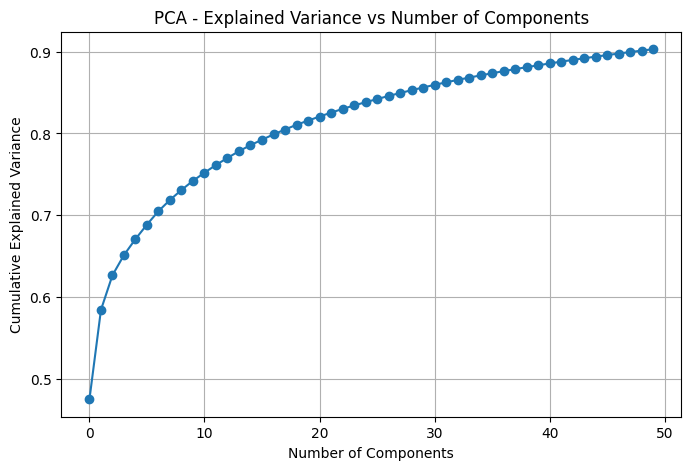

Original shape: (420, 4096)
PCA reduced shape: (420, 50)


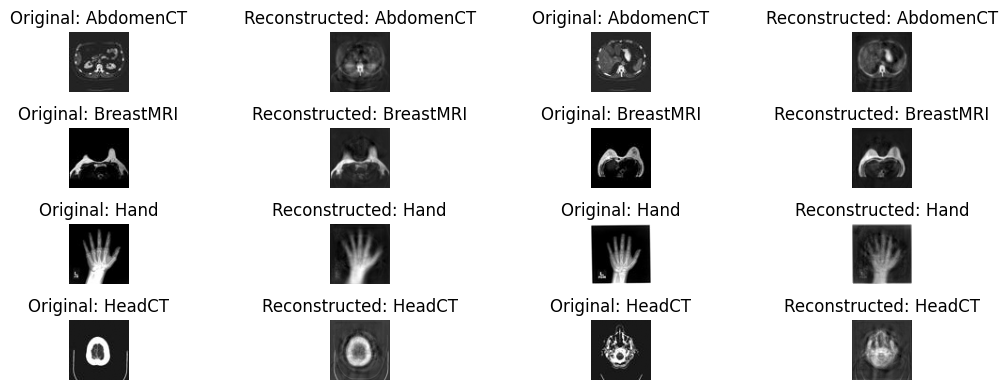

Original image and its PCA vector for each class:



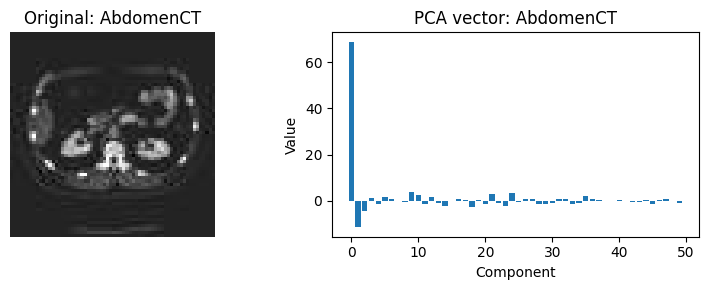

Class: AbdomenCT, PCA vector (first 10 components):
[ 6.89718007e+01 -1.15438802e+01 -4.35180223e+00  1.25463839e+00
 -1.59646617e+00  1.66692684e+00  7.30245567e-01 -5.69682743e-02
 -6.42569544e-01  3.66566897e+00]



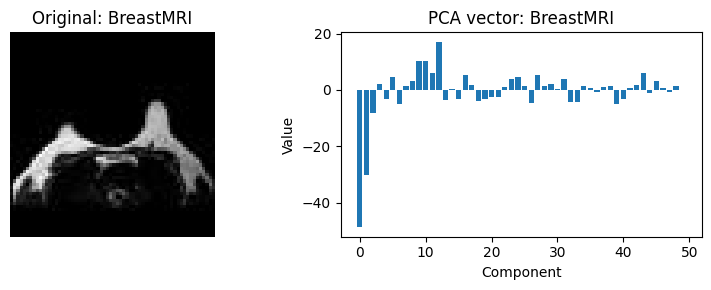

Class: BreastMRI, PCA vector (first 10 components):
[-48.7812024  -30.14213003  -8.04189661   2.03935381  -3.16801371
   4.57685393  -5.117412     1.54239348   3.04254473  10.28337778]



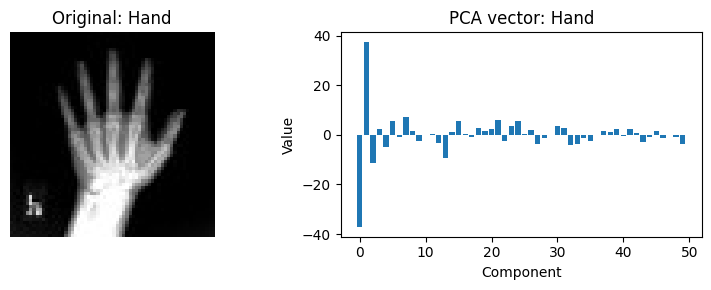

Class: Hand, PCA vector (first 10 components):
[-37.34229163  37.70428071 -11.40124402   2.22398216  -4.66827605
   5.79314297  -0.67039406   7.34536254   1.65889799  -2.30566932]



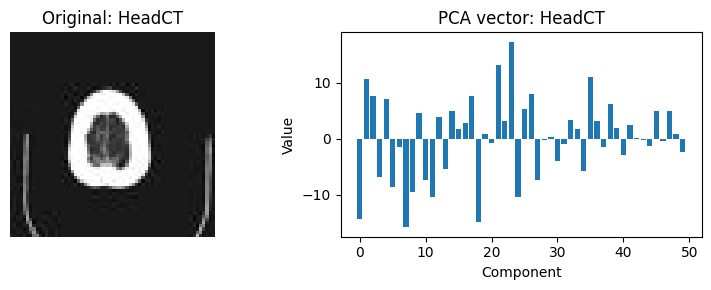

Class: HeadCT, PCA vector (first 10 components):
[-14.26018726  10.7987101    7.66262722  -6.86990736   7.19392771
  -8.63526534  -1.38633102 -15.79101804  -9.51354434   4.55155288]



In [10]:
# PCA and visualization

import os
import numpy as np
from PIL import Image
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt



# Flatten images for PCA
num_samples = X_train.shape[0]
flattened_images = X_train.reshape(num_samples, -1)

# Standardize
scaler = StandardScaler()
flattened_images_std = scaler.fit_transform(flattened_images)

# Apply PCA
# If you apply PCA on the whole data (including the test data) before training the model,
# then you in fact use some information from the test data.
# Thus, you cannot really judge the behaviour of your model using the test data,
# because it is not an unseen data anymore.
n_components = 50
pca = PCA(n_components=n_components)
principal_components = pca.fit_transform(flattened_images_std)

# Plot explained variance
plt.figure(figsize=(8, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA - Explained Variance vs Number of Components')
plt.grid(True)
plt.show()

print(f"Original shape: {flattened_images.shape}")
print(f"PCA reduced shape: {principal_components.shape}")




# Plot the first 5 images of the training set
# Inverse transform to reconstruct images from PCA
reconstructed = pca.inverse_transform(principal_components)
reconstructed_images = scaler.inverse_transform(reconstructed)
reconstructed_images = reconstructed_images.reshape(X_train.shape)

# Plot 2 images per class: original vs reconstructed
unique_classes = np.unique(y_train)
images_per_class = 2

plt.figure(figsize=(10, 4))  # Bigger images

plot_idx = 1
for class_label in unique_classes:
    # Find indices for this class
    class_indices = np.where(y_train == class_label)[0][:images_per_class]
    for i, idx in enumerate(class_indices):
        plt.subplot(len(unique_classes), images_per_class * 2, plot_idx)
        plt.imshow(X_train[idx], cmap='gray')
        plt.title(f"Original: {class_label}")
        plt.axis('off')
        plot_idx += 1

        plt.subplot(len(unique_classes), images_per_class * 2, plot_idx)
        plt.imshow(reconstructed_images[idx], cmap='gray')
        plt.title(f"Reconstructed: {class_label}")
        plt.axis('off')
        plot_idx += 1

plt.tight_layout()
plt.subplots_adjust(wspace=0.4, hspace=0.6)
plt.show()


# For each class, show an original image and its PCA vector (principal component values)
print("Original image and its PCA vector for each class:\n")
for class_label in unique_classes:
    # Find the first index for this class
    idx = np.where(y_train == class_label)[0][0]
    plt.figure(figsize=(8,3))
    
    # Show the original image
    plt.subplot(1,2,1)
    plt.imshow(X_train[idx], cmap='gray')
    plt.title(f"Original: {class_label}")
    plt.axis('off')
    
    # Show the principal component vector as a bar plot
    plt.subplot(1,2,2)
    plt.bar(np.arange(n_components), principal_components[idx])
    plt.title(f"PCA vector: {class_label}")
    plt.xlabel("Component")
    plt.ylabel("Value")
    plt.tight_layout()
    plt.show()
    
    # Print the PCA vector values
    print(f"Class: {class_label}, PCA vector (first 10 components):\n{principal_components[idx][:10]}\n")



In [ ]:
# T-sne only useful for visualization

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# Flatten and standardize the training images
num_samples = X_train.shape[0]
flattened_images = X_train.reshape(num_samples, -1)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
flattened_images_std = scaler.fit_transform(flattened_images)

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(flattened_images_std)
print("t-SNE output shape:", X_tsne.shape)

# Plot t-SNE result, colored by class
plt.figure(figsize=(10, 7))
for class_label in np.unique(y_train):
    idx = np.where(y_train == class_label)
    plt.scatter(X_tsne[idx, 0], X_tsne[idx, 1], label=class_label, s=15)
plt.title("t-SNE Visualization of Training Data")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.legend()
plt.show()

In [ ]:
# Logistic regression whithot PCA

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score

# Flatten images for classification
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# Standardize features
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train_flat)
X_test_std = scaler.transform(X_test_flat)

# Train logistic regression classifier
clf = LogisticRegression(max_iter=1000, random_state=42)
clf.fit(X_train_std, y_train)

# Predict on test set
y_pred = clf.predict(X_test_std)

# Evaluate
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

In [ ]:
# just checkig 
num_samples = X_train.shape[0]
print(f"Number of samples: {num_samples}")
print("---------------------------------------")
flattened_images = X_train.reshape(num_samples, -1)
print(f"Flattened images shape: {flattened_images.shape}")
print("---------------------------------------")
print("pricipal components shape: ", principal_components.shape)
print("---------------------------------------")   
print("principal components=",principal_components)

In [ ]:
# Logistic regreression which uses PCA

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# Flatten and standardize validation and test sets using the same scaler as training
X_test_flat = X_test.reshape(X_test.shape[0], -1)
X_test_std = scaler.transform(X_test_flat)

# Apply PCA transformation using the same PCA fitted on training data
X_test_pca = pca.transform(X_test_std)

# Use PCA-reduced features for training
X_train_pca = principal_components  # Already computed for training set

# Train multiclass logistic regression classifier
clf = LogisticRegression(
    multi_class='multinomial',
    solver='lbfgs',
    max_iter=1000,
    random_state=42
)
clf.fit(X_train_pca, y_train)

# Predict on test set
y_pred = clf.predict(X_test_pca)

# Evaluate
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

In [ ]:
# Assess the model's performance
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score,
    recall_score, f1_score, classification_report, roc_curve, auc
)
from sklearn.preprocessing import label_binarize

def assess_model_performance(clf, X_test, y_test, class_labels=None, title_prefix=""):
    """
    Assess and visualize the performance of a classifier.
    
    Parameters:
        clf: Trained classifier
        X_test: Test features
        y_test: True test labels
        class_labels: List of class labels (optional)
        title_prefix: String to prefix plot titles (optional)
    """
    # Predict
    y_pred = clf.predict(X_test)
    if class_labels is None:
        class_labels = np.unique(y_test)

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred, labels=class_labels)
    print("Confusion Matrix:\n", cm)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    disp.plot(cmap=plt.cm.Greens)
    plt.title(f"{title_prefix} Confusion Matrix")
    plt.show()

    # Accuracy, Precision, Recall, F1
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='macro', zero_division=0)
    rec = recall_score(y_test, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision (macro): {prec:.4f}")
    print(f"Recall (macro): {rec:.4f}")
    print(f"F1 Score (macro): {f1:.4f}")

    # Classification Report
    print("\nClassification Report:\n", classification_report(y_test, y_pred, zero_division=0))

    # ROC Curve (if possible)
    y_score = None
    if hasattr(clf, "predict_proba"):
        y_score = clf.predict_proba(X_test)
    elif hasattr(clf, "decision_function"):
        y_score = clf.decision_function(X_test)

    if y_score is not None:
        y_test_bin = label_binarize(y_test, classes=class_labels)
        plt.figure(figsize=(8, 6))
        for i, class_label in enumerate(class_labels):
            fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, label=f'Class {class_label} (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], 'k--', label='Chance')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'{title_prefix} ROC Curve - All Classes')
        plt.legend(loc="lower right")
        plt.show()
    else:
        print("ROC curve and AUC not available for this classifier.")

# Assess the model's performance
assess_model_performance(clf, X_test_pca, y_test, class_labels=np.unique(y_train), title_prefix="Logistic Regression with PCA")

In [ ]:
# Plotting decision boundary using the first two PCA components
import numpy as np
import matplotlib.pyplot as plt

# Reduce data to 2D for visualization
X_train_2d = X_train_pca[:, :2]
X_test_2d = X_test_pca[:, :2]

# Retrain classifier on 2D PCA data for visualization
clf_2d = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000, random_state=42)
clf_2d.fit(X_train_2d, y_train)

# Create a mesh to plot the decision boundary
x_min, x_max = X_train_2d[:, 0].min() - 1, X_train_2d[:, 0].max() + 1
y_min, y_max = X_train_2d[:, 1].min() - 1, X_train_2d[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300), np.linspace(y_min, y_max, 300))
Z = clf_2d.predict(np.c_[xx.ravel(), yy.ravel()])

# Map class labels to integer indices for contourf
class_labels, Z_int = np.unique(y_train, return_inverse=True)
label_to_int = {label: idx for idx, label in enumerate(class_labels)}
Z_int = np.array([label_to_int[label] for label in Z])
Z_int = Z_int.reshape(xx.shape)

plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z_int, alpha=0.3, cmap=plt.cm.Set1)

# Plot training points
for class_label in np.unique(y_train):
    idx = np.where(y_train == class_label)
    plt.scatter(X_train_2d[idx, 0], X_train_2d[idx, 1], label=class_label, edgecolor='k', s=40)

plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Decision Boundary (Logistic Regression, 2D PCA)')
plt.legend()
plt.show()

In [ ]:
# Grid search for best hyperparameters in Logistic Regression with PCA features

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score
import numpy as np

# Define parameter grid
param_grid = {
    'C': np.logspace(-4,4,20),
    'solver': ['lbfgs', 'saga'],
    'multi_class': ['multinomial'],
    'max_iter': [100,1000,2500, 5000]
}

# Initialize Logistic Regression (no need to set random_state for grid search)
logreg = LogisticRegression()

# GridSearchCV setup
grid_search = GridSearchCV(
    estimator=logreg,
    param_grid=param_grid,
    cv=3,  # 3-fold cross-validation
    n_jobs=-1,
    verbose=2
)

# Fit on PCA-reduced training data
grid_search.fit(X_train_pca, y_train)

# Best parameters and score
print("Best parameters found:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

# Evaluate on test set
y_pred = grid_search.predict(X_test_pca)
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

In [ ]:
# assess_model_performance(grid_search.best_estimator_, X_test_pca, y_test)
assess_model_performance(grid_search.best_estimator_, X_test_pca, y_test, class_labels=np.unique(y_train), title_prefix="Grid Search Logistic Regression with PCA")

In [ ]:
# Logistic regreression which uses LDA

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score


# Train multiclass logistic regression classifier
clf = LogisticRegression(
    multi_class='multinomial',
    solver='lbfgs',
    max_iter=1000,
    random_state=42
)
clf.fit(X_train_lda, y_train)

# Predict on test set
y_pred = clf.predict(X_test_lda)

# Evaluate
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

In [ ]:
assess_model_performance(clf, X_test_lda, y_test, class_labels=np.unique(y_train), title_prefix="Logistic Regression with LDA")

In [15]:
# Grid search for best hyperparameters in Logistic Regression with LDA features

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score
import numpy as np

# Define parameter grid
param_grid = {
    'C': np.logspace(-4, 4, 20),
    'solver': ['lbfgs', 'saga'],
    'multi_class': ['multinomial'],
    'max_iter': [100, 1000, 2500, 5000]
}

# Initialize Logistic Regression
logreg = LogisticRegression()

# GridSearchCV setup
grid_search = GridSearchCV(
    estimator=logreg,
    param_grid=param_grid,
    cv=3,  # 3-fold cross-validation
    n_jobs=-1,
    verbose=2
)

# Fit on LDA-reduced training data
grid_search.fit(X_train_lda, y_train)

# Best parameters and score
print("Best parameters found:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

# Evaluate on test set
y_pred = grid_search.predict(X_test_lda)
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# not much change in the performance of the model
#  and for that reason will not do plots

Best parameters found: {'C': 0.0001, 'max_iter': 100, 'multi_class': 'multinomial', 'solver': 'lbfgs'}
Best cross-validation score: 1.0
Test Accuracy: 0.9833333333333333

Classification Report:
               precision    recall  f1-score   support

   AbdomenCT       0.94      1.00      0.97        45
   BreastMRI       1.00      1.00      1.00        45
        Hand       1.00      0.93      0.97        45
      HeadCT       1.00      1.00      1.00        45

    accuracy                           0.98       180
   macro avg       0.98      0.98      0.98       180
weighted avg       0.98      0.98      0.98       180



c:\Users\odys_\Desktop\ML_winows_2\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Confusion Matrix:
 [[45  0  0  0]
 [ 0 45  0  0]
 [ 3  0 42  0]
 [ 0  0  0 45]]


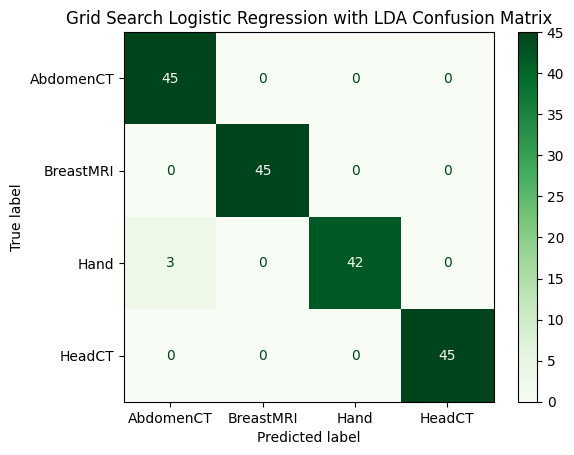

Accuracy: 0.9833
Precision (macro): 0.9844
Recall (macro): 0.9833
F1 Score (macro): 0.9833

Classification Report:
               precision    recall  f1-score   support

   AbdomenCT       0.94      1.00      0.97        45
   BreastMRI       1.00      1.00      1.00        45
        Hand       1.00      0.93      0.97        45
      HeadCT       1.00      1.00      1.00        45

    accuracy                           0.98       180
   macro avg       0.98      0.98      0.98       180
weighted avg       0.98      0.98      0.98       180



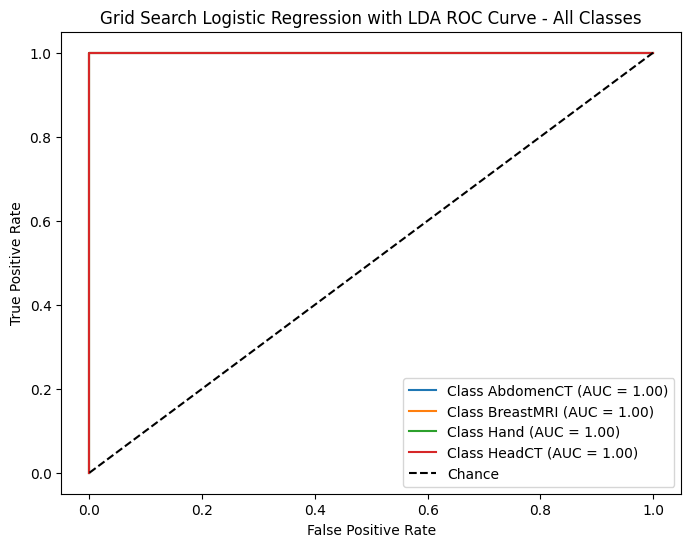

In [16]:
assess_model_performance(grid_search.best_estimator_, X_test_lda, y_test, class_labels=np.unique(y_train), title_prefix="Grid Search Logistic Regression with LDA")

In [ ]:
# Classification SVM without PCA

from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score

# Flatten images for classification
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# Standardize features
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train_flat)
X_test_std = scaler.transform(X_test_flat)

# Train SVM on PCA-reduced features
svm_clf = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)
svm_clf.fit(X_train_std, y_train)

# Predict on test set
y_pred = svm_clf.predict(X_test_std)

# Evaluate
print("SVM Test Accuracy:", accuracy_score(y_test, y_pred))
print("\nSVM Classification Report:\n", classification_report(y_test, y_pred))

In [ ]:
# Classification SVM with PCA

from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score

# Train SVM on PCA-reduced features
svm_clf = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)
svm_clf.fit(X_train_pca, y_train)

# Predict on test set
y_pred = svm_clf.predict(X_test_pca)

# Evaluate
print("SVM Test Accuracy:", accuracy_score(y_test, y_pred))
print("\nSVM Classification Report:\n", classification_report(y_test, y_pred))

In [ ]:
assess_model_performance(svm_clf, X_test_pca, y_test, class_labels=np.unique(y_train), title_prefix="SVM with PCA")

In [ ]:
# Grid search for best hyperparameters in SVM with PCA features

from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score

# Define parameter grid for SVM
param_grid = {
    'C': [0.1, 1, 10, 100, 1000],
    'gamma': ['scale', 0.0001, 0.001, 0.01, 0.1, 1],
    'kernel': ['rbf']
}

# Initialize SVM classifier
svm = SVC()

# GridSearchCV setup
grid_search = GridSearchCV(
    estimator=svm,
    param_grid=param_grid,
    cv=3,  # 3-fold cross-validation
    n_jobs=-1,
    verbose=2
)

# Fit on PCA-reduced training data
grid_search.fit(X_train_pca, y_train)

# Best parameters and score
print("Best parameters found:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

# Evaluate on test set
y_pred = grid_search.predict(X_test_pca)
print("SVM Test Accuracy:", accuracy_score(y_test, y_pred))
print("\nSVM Classification Report:\n", classification_report(y_test, y_pred))

In [ ]:
assess_model_performance(grid_search.best_estimator_, X_test_pca, y_test, class_labels=np.unique(y_train), title_prefix="Grid Search Logistic Regression with LDA")

In [ ]:
# Classification SVM with LDA

from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score

# Train SVM on PCA-reduced features
svm_clf = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)
svm_clf.fit(X_train_lda, y_train)

# Predict on test set
y_pred = svm_clf.predict(X_test_lda)

# Evaluate
print("SVM Test Accuracy:", accuracy_score(y_test, y_pred))
print("\nSVM Classification Report:\n", classification_report(y_test, y_pred))

In [ ]:
assess_model_performance(svm_clf, X_test_lda, y_test, class_labels=np.unique(y_train), title_prefix="SVM with LDA")

In [ ]:
# Grid search for best hyperparameters in SVM with LDA features

from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score

# Define parameter grid for SVM
param_grid = {
    'C': [0.1, 1, 10, 100, 1000],
    'gamma': [0.0001, 0.001, 0.01, 0.1, 1],
    'kernel': ['rbf']
}

# Initialize SVM classifier
svm = SVC()

# GridSearchCV setup
grid_search = GridSearchCV(
    estimator=svm,
    param_grid=param_grid,
    cv=3,  # 3-fold cross-validation
    n_jobs=-1,
    verbose=2
)

# Fit on LDA-reduced training data
grid_search.fit(X_train_lda, y_train)

# Best parameters and score
print("Best parameters found:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

# Evaluate on test set
y_pred = grid_search.predict(X_test_lda)
print("SVM Test Accuracy:", accuracy_score(y_test, y_pred))
print("\nSVM Classification Report:\n", classification_report(y_test, y_pred))

In [ ]:
assess_model_performance(grid_search.best_estimator_, X_test_lda, y_test, class_labels=np.unique(y_train), title_prefix="Grid Search SVM with LDA")

In [ ]:
# KNN classification without PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score

# Flatten images for classification
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# Standardize features
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train_flat)
X_test_std = scaler.transform(X_test_flat)

# Create and train the KNN classifier
knn = KNeighborsClassifier(n_neighbors=5)  # You can adjust n_neighbors
knn.fit(X_train_std, y_train)

# Predict on test set
y_pred = knn.predict(X_test_std)

# Evaluate
print("KNN Test Accuracy:", accuracy_score(y_test, y_pred))
print("\nKNN Classification Report:\n", classification_report(y_test, y_pred))

In [ ]:
# KNN classification with PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score

# Use PCA-reduced features for training and testing
# X_train_pca, X_test_pca, y_train, y_test should already be defined

# Create and train the KNN classifier
knn = KNeighborsClassifier(n_neighbors=5)  # You can adjust n_neighbors
knn.fit(X_train_pca, y_train)

# Predict on test set
y_pred = knn.predict(X_test_pca)

# Evaluate
print("KNN Test Accuracy:", accuracy_score(y_test, y_pred))
print("\nKNN Classification Report:\n", classification_report(y_test, y_pred))

In [ ]:
assess_model_performance(knn, X_test_pca, y_test)

In [ ]:
# Grid search for best hyperparameters in KNN with PCA features

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score

# Define parameter grid for KNN
param_grid = {
    'n_neighbors': np.arange(2, 30, 1),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

# Initialize KNN classifier
knn = KNeighborsClassifier()

# GridSearchCV setup
grid_search = GridSearchCV(
    estimator=knn,
    param_grid=param_grid,
    cv=3,  # 3-fold cross-validation
    n_jobs=-1,
    verbose=2
)


# Fit on PCA-reduced training data
grid_search.fit(X_train_pca, y_train)

# Best parameters and score
print("Best parameters found:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

# Evaluate on test set
y_pred = grid_search.predict(X_test_pca)
print("KNN Test Accuracy:", accuracy_score(y_test, y_pred))
print("\nKNN Classification Report:\n", classification_report(y_test, y_pred))

In [ ]:
assess_model_performance(grid_search.best_estimator_, X_test_pca, y_test, class_labels=np.unique(y_train), title_prefix="Grid Search KNN with PCA")

In [ ]:
#  custom KNN hyperparameter tuning
train_score = {}
test_score = {}
n_neighbors = np.arange(2, 30, 1)
for neighbor in n_neighbors:
    knn = KNeighborsClassifier(n_neighbors=neighbor)
    knn.fit(X_train_pca, y_train)
    train_score[neighbor]=knn.score(X_train_pca, y_train)
    test_score[neighbor]=knn.score(X_test_pca, y_test)


for key, value in test_score.items():
    if value==max(test_score.values()):
        best_no_neighbors = key
        print(best_no_neighbors)

# https://medium.com/@agrawalsam1997/hyperparameter-tuning-of-knn-classifier-a32f31af25c7

In [ ]:
# KNN classification with PCA and custom hyperparameter tuning
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score

# Use PCA-reduced features for training and testing
# X_train_pca, X_test_pca, y_train, y_test should already be defined

# Create and train the KNN classifier
knn = KNeighborsClassifier(n_neighbors=best_no_neighbors)  # You can adjust n_neighbors
knn.fit(X_train_pca, y_train)

# Predict on test set
y_pred = knn.predict(X_test_pca)

# Evaluate
print("KNN Test Accuracy:", accuracy_score(y_test, y_pred))
print("\nKNN Classification Report:\n", classification_report(y_test, y_pred))

In [ ]:
# KNN classification with LDA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score

# Create and train the KNN classifier
knn = KNeighborsClassifier(n_neighbors=5)  # You can adjust n_neighbors
knn.fit(X_train_lda, y_train)

# Predict on test set
y_pred = knn.predict(X_test_lda)

# Evaluate
print("KNN Test Accuracy:", accuracy_score(y_test, y_pred))
print("\nKNN Classification Report:\n", classification_report(y_test, y_pred))

In [ ]:
# Grid search for best hyperparameters in KNN with LDA features

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score
import numpy as np

# Define parameter grid for KNN
param_grid = {
    'n_neighbors': np.arange(2, 30, 1),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

# Initialize KNN classifier
knn = KNeighborsClassifier()

# GridSearchCV setup
grid_search = GridSearchCV(
    estimator=knn,
    param_grid=param_grid,
    cv=3,  # 3-fold cross-validation
    n_jobs=-1,
    verbose=2
)

# Fit on LDA-reduced training data
grid_search.fit(X_train_lda, y_train)

# Best parameters and score
print("Best parameters found:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

# Evaluate on test set
y_pred = grid_search.predict(X_test_lda)
print("KNN Test Accuracy:", accuracy_score(y_test, y_pred))
print("\nKNN Classification Report:\n", classification_report(y_test, y_pred))

In [ ]:
assess_model_performance(grid_search.best_estimator_, X_test_lda, y_test, class_labels=np.unique(y_train), title_prefix="Grid Search KNN with LDA")

In [ ]:
# Naive Bayes classification without PCA

from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score

# Flatten images for classification
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# Standardize features
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train_flat)
X_test_std = scaler.transform(X_test_flat)

# Train Naive Bayes classifier
nb_clf = GaussianNB()
nb_clf.fit(X_train_std, y_train)

# Predict on test set
y_pred = nb_clf.predict(X_test_std)

# Evaluate
print("Naive Bayes Test Accuracy:", accuracy_score(y_test, y_pred))
print("\nNaive Bayes Classification Report:\n", classification_report(y_test, y_pred))

In [ ]:
# Naive Bayes classification with PCA

from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score

# Train Naive Bayes classifier
nb_clf = GaussianNB()
nb_clf.fit(X_train_pca, y_train)

# Predict on test set
y_pred = nb_clf.predict(X_test_pca)

# Evaluate
print("Naive Bayes Test Accuracy:", accuracy_score(y_test, y_pred))
print("\nNaive Bayes Classification Report:\n", classification_report(y_test, y_pred))

In [ ]:
assess_model_performance(nb_clf, X_test_pca, y_test)

In [ ]:
# Grid search for best hyperparameters in Naive Bayes with PCA features

from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score
import numpy as np

# Define parameter grid for GaussianNB
param_grid = {
    'var_smoothing': np.logspace(0, -50, 10)  # Typical range for var_smoothing
}

# Initialize GaussianNB classifier
nb = GaussianNB()

# GridSearchCV setup
grid_search = GridSearchCV(
    estimator=nb,
    param_grid=param_grid,
    cv=3,  # 3-fold cross-validation
    n_jobs=-1,
    verbose=2
)

# Fit on PCA-reduced training data
grid_search.fit(X_train_pca, y_train)

# Best parameters and score
print("Best parameters found:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

# Evaluate on test set
y_pred = grid_search.predict(X_test_pca)
print("Naive Bayes Test Accuracy:", accuracy_score(y_test, y_pred))
print("\nNaive Bayes Classification Report:\n", classification_report(y_test, y_pred))

In [ ]:
# Naive Bayes classification with LDA

from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score

# Train Naive Bayes classifier
nb_clf = GaussianNB()
nb_clf.fit(X_train_lda, y_train)

# Predict on test set
y_pred = nb_clf.predict(X_test_lda)

# Get parameters
print("Naive Bayes Classifier Parameters:", nb_clf.get_params())

# Evaluate
print("Naive Bayes Test Accuracy:", accuracy_score(y_test, y_pred))
print("\nNaive Bayes Classification Report:\n", classification_report(y_test, y_pred))

In [ ]:
assess_model_performance(nb_clf, X_test_lda, y_test, class_labels=np.unique(y_train), title_prefix="Naive Bayes with LDA")

In [ ]:
# Grid search for best hyperparameters in Naive Bayes with LDA features

from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score
import numpy as np

# Define parameter grid for GaussianNB
param_grid = {
    'var_smoothing': np.logspace(0, -9, 100)  # Typical range for var_smoothing
}

# Initialize GaussianNB classifier
nb = GaussianNB()

# GridSearchCV setup
grid_search = GridSearchCV(
    estimator=nb,
    param_grid=param_grid,
    cv=3,  # 3-fold cross-validation
    n_jobs=-1,
    verbose=2
)

# Fit on PCA-reduced training data
grid_search.fit(X_train_lda, y_train)

# Best parameters and score
print("Best parameters found:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

# Evaluate on test set
y_pred = grid_search.predict(X_test_lda)
print("Naive Bayes Test Accuracy:", accuracy_score(y_test, y_pred))
print("\nNaive Bayes Classification Report:\n", classification_report(y_test, y_pred))

In [ ]:
assess_model_performance(grid_search.best_estimator_, X_test_lda, y_test)

In [ ]:
# MLP Neural Network classification with LDA features

from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score

# Initialize the MLPClassifier
mlp_lda = MLPClassifier(
    hidden_layer_sizes=(100,),  # You can adjust the size and number of layers
    activation='relu',
    solver='adam',
    max_iter=300,
    random_state=42,
    verbose=True
)

# Fit the model on LDA-reduced training data
mlp_lda.fit(X_train_lda, y_train)

# Predict on test set
y_pred = mlp_lda.predict(X_test_lda)

# Evaluate
print("MLP Test Accuracy:", accuracy_score(y_test, y_pred))
print("\nMLP Classification Report:\n", classification_report(y_test, y_pred))

In [ ]:
assess_model_performance(mlp_lda, X_test_lda, y_test, class_labels=np.unique(y_train), title_prefix="MLP with LDA")

In [ ]:
# Grid search for best hyperparameters in MLP Neural Network with LDA features

from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score
import numpy as np

# Define parameter grid for MLP
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (100, 50), (150,)],
    'activation': ['relu', 'tanh', "logistic"],
    'solver': ['adam', 'sgd'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'adaptive'],
    'max_iter': [300]
}

# Initialize MLPClassifier
mlp = MLPClassifier(random_state=42)

# GridSearchCV setup
grid_search_MLP_LDA = GridSearchCV(
    estimator=mlp,
    param_grid=param_grid,
    cv=3,  # 3-fold cross-validation
    n_jobs=-1,
    verbose=2
)

# Fit on LDA-reduced training data
grid_search_MLP_LDA.fit(X_train_lda, y_train)

# Best parameters and score
print("Best parameters found:", grid_search_MLP_LDA.best_params_)
print("Best cross-validation score:", grid_search_MLP_LDA.best_score_)

# Evaluate on test set
y_pred = grid_search_MLP_LDA.predict(X_test_lda)
print("MLP Test Accuracy:", accuracy_score(y_test, y_pred))
print("\nMLP Classification Report:\n", classification_report(y_test, y_pred))

In [ ]:
# Plot learning curve for MLP classifier with LDA features

from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import numpy as np

# Use the best estimator from grid search, or define your own
mlp = grid_search_MLP_LDA.best_estimator_

train_sizes, train_scores, test_scores = learning_curve(
    mlp,
    X_train_lda,
    y_train,
    cv=3,
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 8),
    verbose=2
)

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
plt.title("Learning Curve (MLP Classifier with LDA features)")
plt.xlabel("Training examples")
plt.ylabel("Accuracy Score")
plt.legend(loc="best")
plt.grid(True)
plt.show()

In [ ]:
# MLP Neural Network classification with PCA features

from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score

# Initialize the MLPClassifier
mlp_pca = MLPClassifier(
    hidden_layer_sizes=(100,),  # You can adjust the size and number of layers
    activation='relu',
    solver='adam',
    max_iter=300,
    random_state=42,
    verbose=True
)

# Fit the model on PCA-reduced training data
mlp_pca.fit(X_train_pca, y_train)

# Predict on test set
y_pred = mlp_pca.predict(X_test_pca)

# Evaluate
print("MLP Test Accuracy:", accuracy_score(y_test, y_pred))
print("\nMLP Classification Report:\n", classification_report(y_test, y_pred))

In [ ]:
assess_model_performance(mlp_pca, X_test_pca, y_test, class_labels=np.unique(y_train), title_prefix="MLP with PCA")

from  Practical deep learning : a python-based introduction / Ronald T. Kneusel. page 177 

Selecting the proper neural network architecture has a huge impact on 
whether or not your model will learn anything. This is where experience 
and intuition come in. Selecting the right architecture is the dark art of 
using neural networks. Let’s try to be more helpful by giving some (crude) 
rules of thumb:

• If your input has definite spatial relationships, like the parts of an
image, you might want to use a convolutional neural network in-
stead (Chapter 12).

• Use no more than three hidden layers. Recall, in theory, one suffi-
ciently large hidden layer is all that is needed, so use as few hidden
layers as necessary. If the model learns with one hidden layer, then 
add a second to see if that improves things.

• The number of nodes in the first hidden layer should match or (ide-
ally) exceed the number of input vector features.

• Except for the first hidden layer (see previous rule), the number
of nodes per hidden layer should be the same as or some value be-
tween the number of nodes in the previous layer and the following 
layer. If layer i – 1 has N nodes and layer i + 1 has M nodes, then layer 
i might be good with N ≤ x ≤ M nodes.

The first rule says that a traditional neural network best applies to situa-
tions where your input does not have spatial relationships—that is, you have
a feature vector, not an image. Also, when your input dimension is small,
or when you do not have a lot of data, which makes it hard to train a larger 
convolutional network, you should give a traditional network a try. If you do 
think you are in a situation where a traditional neural network is called for, 
start small, and grow it as long as performance improves.

In [ ]:
# Grid search for best hyperparameters in MLP Neural Network with PCA features

from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score
import numpy as np

# Define parameter grid for MLP
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (100, 50), (150,)],
    'activation': ['relu', 'tanh', 'logistic'],
    'solver': ['adam', 'sgd'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'adaptive'],
    'max_iter': [300]
}

# Initialize MLPClassifier
mlp = MLPClassifier(random_state=42)

# GridSearchCV setup
grid_search_MLP_PCA = GridSearchCV(
    estimator=mlp,
    param_grid=param_grid,
    cv=3,  # 3-fold cross-validation
    n_jobs=-1,
    verbose=2
)

# Fit on PCA-reduced training data
grid_search_MLP_PCA.fit(X_train_pca, y_train)

# Best parameters and score
print("Best parameters found:", grid_search_MLP_PCA.best_params_)
print("Best cross-validation score:", grid_search_MLP_PCA.best_score_)

# Evaluate on test set
y_pred = grid_search_MLP_PCA.predict(X_test_pca)
print("MLP Test Accuracy:", accuracy_score(y_test, y_pred))
print("\nMLP Classification Report:\n", classification_report(y_test, y_pred))

In [ ]:
# Plot learning curve for MLP classifier with PCA features

from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import numpy as np

# Use the best estimator from grid search, or define your own
mlp = grid_search_MLP_PCA.best_estimator_

train_sizes, train_scores, test_scores = learning_curve(
    mlp,
    X_train_pca,
    y_train,
    cv=3,
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 8),
    verbose=2
)

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
plt.title("Learning Curve (MLP Classifier with PCA features)")
plt.xlabel("Training examples")
plt.ylabel("Accuracy Score")
plt.legend(loc="best")
plt.grid(True)
plt.show()